# Google Trends Data Scrape

In [1]:
%load_ext lab_black
%matplotlib inline

In [12]:
import pytrends
from pytrends.request import TrendReq

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import seaborn as sns

from collections import defaultdict

plt.style.use("fivethirtyeight")

In [3]:
pt = TrendReq(hl="en-US", tz=360)

In [10]:
# df = pt.get_historical_interest(
#     kw_list,
#     year_start=2018,
#     month_start=1,
#     day_start=1,
#     hour_start=0,
#     year_end=2018,
#     month_end=2,
#     day_end=1,
#     hour_end=0,
#     cat=0,
#     geo="",
#     gprop="",
#     sleep=0,
# )

# Normalizing Google Trends Data
- Pull trends data for 32 NFL Teams
- Goal get the normalized google trend of each team in the NFL relative to all other 32 teams.

In [5]:
nfl_teams = [
    "Arizona Cardinals",
    "Atlanta Falcons",
    "Baltimore Ravens",
    "Buffalo Bills",
    "Carolina Panthers",
    "Chicago Bears",
    "Cincinnati Bengals",
    "Cleveland Browns",
    "Dallas Cowboys",
    "Denver Broncos",
    "Detroit Lions",
    "Green Bay Packers",
    "Houston Texans",
    "Indianapolis Colts",
    "Jacksonville Jaguars",
    "Kansas City Chiefs",
    "Las Vegas Raiders",
    "Los Angeles Chargers",
    "Los Angeles Rams",
    "Miami Dolphins",
    "Minnesota Vikings",
    "New England Patriots",
    "New Orleans Saints",
    "New York Giants",
    "New York Jets",
    "Philadelphia Eagles",
    "Pittsburgh Steelers",
    "San Francisco 49ers",
    "Seattle Seahawks",
    "Tampa Bay Buccaneers",
    "Tennessee Titans",
    "Washington Football Team",
]

In [6]:
# Pull Each individually
all_ttrends = []
for t in nfl_teams:
    pt = TrendReq(hl="en-US", tz=360)
    pt.build_payload([t], cat=0, timeframe="all", geo="", gprop="")
    ttrends = pt.interest_over_time()
    all_ttrends.append(ttrends)
ttrend_joined = pd.concat(all_ttrends, axis=1).drop("isPartial", axis=1)

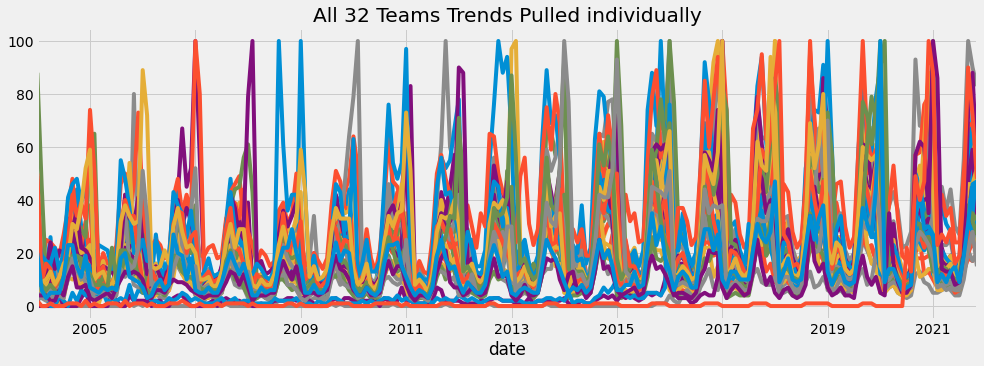

In [11]:
ax = (
    pd.concat(all_ttrends, axis=1)
    .drop("isPartial", axis=1)
    .plot(figsize=(15, 5), title="All 32 Teams Trends Pulled individually")
)
ax.legend().remove()
plt.show()

## Pull Trends in Chunks of 4

In [258]:
# res = defaultdict(list)
res = {}
for t in nfl_teams:
    if t == "Dallas Cowboys":
        continue
    query_teams = [t, "Dallas Cowboys"]
    pt.build_payload(query_teams, cat=0, timeframe="all", geo="", gprop="")
    ttrends = pt.interest_over_time()
    ttrends = ttrends.query('isPartial == "False"')

    df = pd.DataFrame()
    df["scaled"] = ttrends[t]
    df["full"] = ttrend_joined[t]
    df_ = df.query("scaled > 1 and full > 1").copy()
    ratio = (df_["scaled"] / df_["full"]).median()
    # print(f"Ratio of {t} to {max_team} is {ratio}")
    res[t] = ratio

In [273]:
ttrend_norm = ttrend_joined.copy()
for t in nfl_teams:
    if t == "Dallas Cowboys":
        continue
    ttrend_norm
    ttrend_joined[t]
    ttrend_norm[t] = ttrend_joined[t] * res[t]

In [302]:
ttrend_norm_ = (
    ttrend_norm.unstack().reset_index().rename(columns={"level_0": "Team", 0: "Trend"})
)
ttrend_norm_.query("Trend > 30")["Team"].value_counts()

Dallas Cowboys          67
Green Bay Packers        8
Chicago Bears            6
Carolina Panthers        4
Denver Broncos           3
Seattle Seahawks         3
Kansas City Chiefs       2
Philadelphia Eagles      2
Atlanta Falcons          1
Buffalo Bills            1
Cleveland Browns         1
New England Patriots     1
Name: Team, dtype: int64

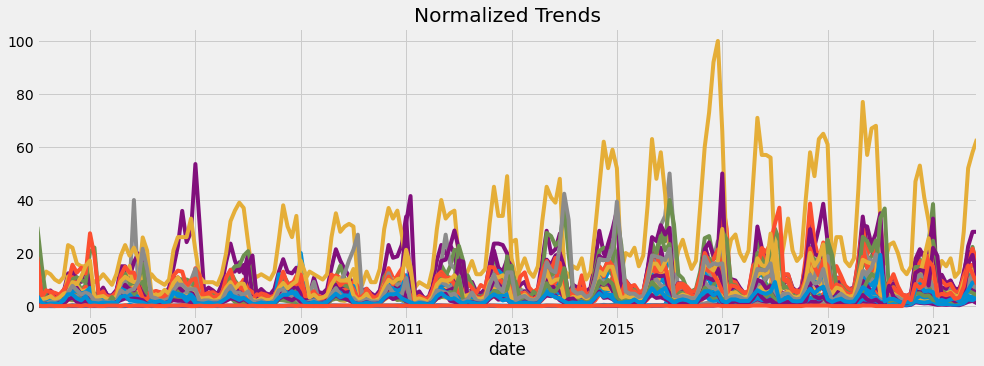

In [305]:
ax = ttrend_norm.plot(figsize=(15, 5), title="Normalized Trends")
ax.legend().remove()

# Rerun for Team Name Only

In [315]:
# Pull Each individually
def get_individual_trends(terms):
    all_ttrends = []
    for t in terms:
        pt = TrendReq(hl="en-US", tz=360)
        pt.build_payload([t], cat=0, timeframe="all", geo="", gprop="")
        ttrends = pt.interest_over_time()
        all_ttrends.append(ttrends)
    ttrend_joined = pd.concat(all_ttrends, axis=1).drop("isPartial", axis=1)
    return ttrend_joined


def get_term_ratios(max_term, ttrend_joined):
    res = {}
    for t in nfl_names:
        if t == max_term:
            continue
        query_terms = [t, max_term]
        pt.build_payload(query_terms, cat=0, timeframe="all", geo="", gprop="")
        ttrends = pt.interest_over_time()
        ttrends = ttrends.query('isPartial == "False"')

        df = pd.DataFrame()
        df["scaled"] = ttrends[t]
        df["full"] = ttrend_joined[t]
        df_ = df.query("scaled > 1 and full > 1").copy()
        ratio = (df_["scaled"] / df_["full"]).median()
        res[t] = ratio
    return res


def get_normed_ttreds(ttrend_joined, terms, max_term):
    ttrend_norm = ttrend_joined.copy()
    for t in terms:
        if t == max_term:
            continue
        ttrend_norm
        ttrend_joined[t]
        ttrend_norm[t] = ttrend_joined[t] * res[t]
    return ttrend_norm

In [333]:
nfl_names = [t.split(" ")[-1] for t in nfl_teams][:-1]

max_term = "Saints"
print("Pulling Trends...")
ttrend_joined = get_individual_trends(nfl_names)
print("Getting Ratios...")
res = get_term_ratios(max_term, ttrend_joined)
print("Joining...")
ttred_norm = get_normed_ttreds(ttrend_joined, nfl_names, max_term)

Pulling Trends...
Getting Ratios...
Joining...


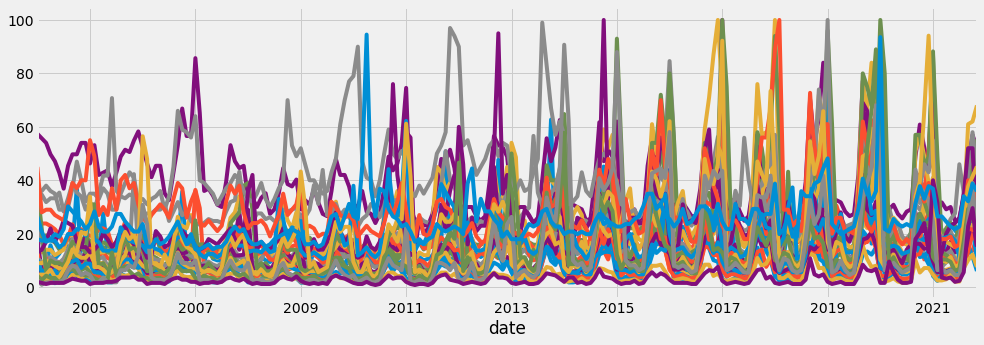

In [334]:
ax = ttred_norm.plot(figsize=(15, 5)).legend().remove()

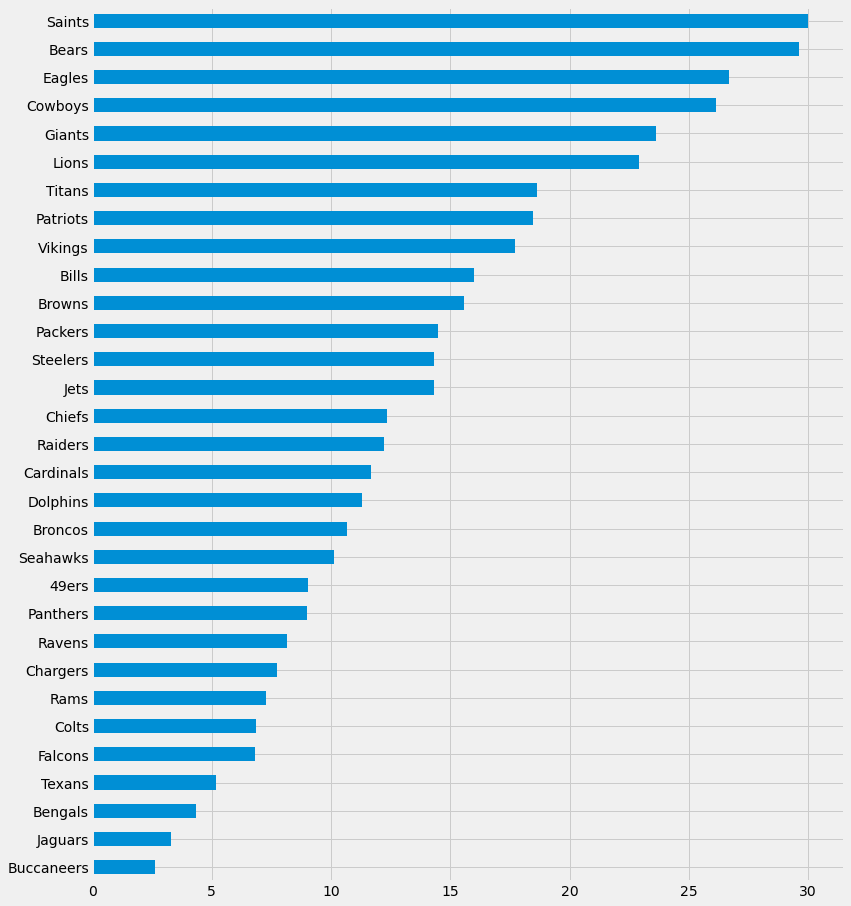

In [332]:
ttred_norm.mean().sort_values().plot(kind="barh", figsize=(12, 15))